In [69]:
import cv2
import numpy as np

import glob

import time

import pickle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

In [70]:
# load the dataset
# path_dataset_vehicle = ./dataset/vehicles
# path_dataset_nonvehicle = ./dataset/non-vehicles

# vehicles

veh_gti_far = glob.glob('./dataset/vehicles/GTI_Far/*.png')
veh_gti_l = glob.glob('./dataset/vehicles/GTI_Left/*.png')
veh_gti_mid_close = glob.glob('./dataset/vehicles/GTI_MiddleClose/*.png')
veh_gti_r = glob.glob('./dataset/vehicles/GTI_Right/*.png')
veh_kitti = glob.glob('./dataset/vehicles/KITTI_extracted/*.png')

#non vehicles
nonveh_extras = glob.glob('./dataset/non-vehicles/Extras/*.png')
nonveh_gti = glob.glob('./dataset/non-vehicles/GTI/*.png')

# evaluate the dataset
len_veh_gti_far = len(veh_gti_far)
len_veh_gti_l = len(veh_gti_l)
len_veh_gti_mid_close = len(veh_gti_mid_close)
len_veh_gti_r = len(veh_gti_r)
len_veh_kitti = len(veh_kitti)
len_all_veh = len_veh_gti_far + len_veh_gti_l + len_veh_gti_mid_close \
    + len_veh_gti_r + len_veh_kitti


len_nonveh_extras = len(nonveh_extras)
len_nonveh_gti = len(nonveh_gti)
len_all_non_veh =len_nonveh_extras+len_nonveh_gti

print('veh_gti_far length: \t{}' .format(len_veh_gti_far))
print('veh_gti_l length: \t{}' .format(len_veh_gti_l))
print('veh_gti_far length: \t{}' .format(len_veh_gti_mid_close))
print('veh_gti_far length: \t{}' .format(len_veh_gti_r))
print('veh_gti_far length: \t{}' .format(len_veh_kitti))
print('nonveh_extras length: \t{}' .format(len_nonveh_extras))
print('nonveh_gti length: \t{}' .format(len_nonveh_gti))

print('Total Vehicles: {} Total Non Vehicles: {}' .format(len_all_veh,len_all_non_veh ))

veh_gti_far length: 	834
veh_gti_l length: 	909
veh_gti_far length: 	419
veh_gti_far length: 	664
veh_gti_far length: 	5966
nonveh_extras length: 	5068
nonveh_gti length: 	3900
Total Vehicles: 8792 Total Non Vehicles: 8968


In [71]:
# shuffle and split the data 
all_veh = veh_gti_far + veh_gti_l + veh_gti_mid_close \
    + veh_gti_r + veh_kitti

all_non_veh = nonveh_extras + nonveh_gti

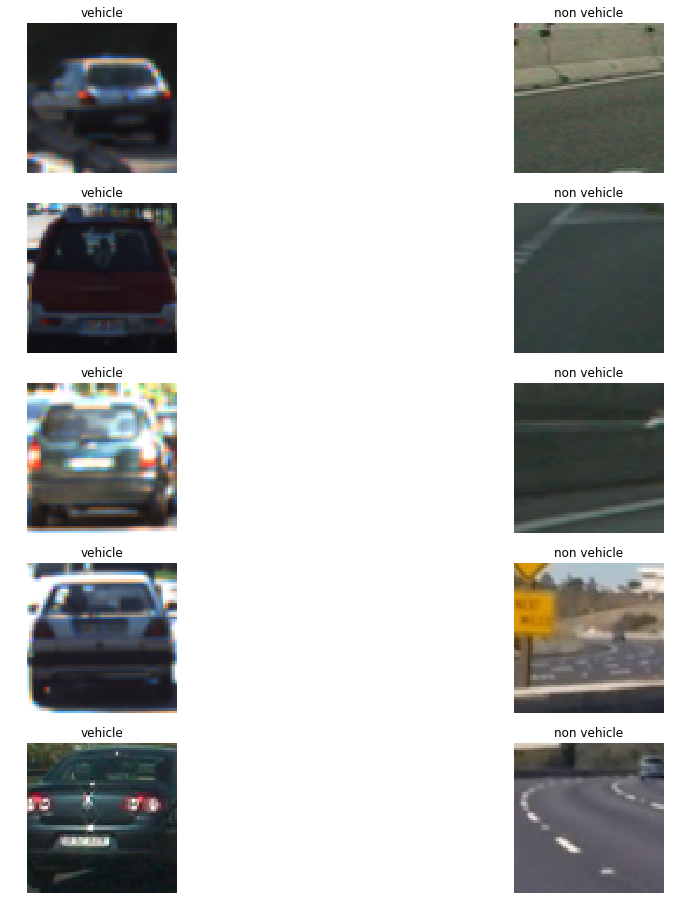

In [72]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (32,32)
# plt.rcParams['figure.figsize'] = (10.0, 8.0)
# matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

#print ('rows: {}' .format(rows))

n_examples = 5
columns = 2
w = 16
h = 16
# fig=plt.figure(figsize=(180, 160), dpi= 80, facecolor='w', edgecolor='k')
fig, axes = plt.subplots(n_examples,columns, figsize=(w,h))
axes = axes.ravel()
for i in range(len(axes)):
    axes[i].axis('off')
    
# iterate through the classes and pull together useful information
for i in range(n_examples): 
    axes[i * 2].imshow(mpimg.imread(all_veh[np.random.randint(0,len(all_veh)-1)]))
    axes[i * 2].set_title('vehicle')
    axes[i * 2 +1].imshow(mpimg.imread(all_non_veh[np.random.randint(0,len(all_non_veh)-1)]))
    axes[i * 2 +1].set_title('non vehicle')
    
plt.savefig('./output_images/sample_images.png',bbox_inches='tight')

In [73]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                       visualise=False, feature_vector=feature_vec)
        return features

In [74]:
def plot_figure(array_to_plot, labels_array, n_rows, n_columns, figuresize=(64,64),colourmap='gray'):
    fig, axes = plt.subplots( n_rows, n_columns,figsize=figuresize)
    axes = axes.ravel()

    for i in range(len(array_to_plot)):
        print('i {}'.format(i))
        print('title {}'.format(labels_array[i]))
        axes[i].imshow(array_to_plot[i], cmap=colourmap)
        axes[i].set_title(labels_array[i])
        axes[i].axis('off')

    # TODO Reinstate
    plt.tight_layout()
    plt.show()

In [75]:
def explore_hog(veh_img,gray,filename):
    
    save_filename = './output_images/'+ filename+'.png'
    print(save_filename)
    plt.rcParams['figure.figsize'] = (32,20)
    print ('function to visualise the dataset and hog output')

    i=0
    rows = 2
    columns = 4
    w = 16
    h = 16
    
    # fig=plt.figure(figsize=(180, 160), dpi= 80, facecolor='w', edgecolor='k')
    fig, axes = plt.subplots(rows,columns)#, figsize=(w,h))
    fig.subplots_adjust(hspace = .001, wspace=.002)
#     plt.tight_layout()
    axes = axes.ravel()
#     fig = plt.figure(figsize=(64,64))

    
    # for i in range(len(axes)):
    #     axes[i].axis('off')
        
    # iterate through the classes and pull together useful information
    # for i in range(n_examples): 
    # veh_img = mpimg.imread(all_veh[rnd])
    axes[i*0].set_title('vehicle')   
    axes[i*0].imshow(veh_img)

    axes[i*4+1].set_title('chn0')     
    axes[i*4+1].imshow(veh_img[:,:,0], cmap='gray')
    axes[i*4+2].set_title('chn1')
    axes[i*4+2].imshow(veh_img[:,:,1], cmap='gray')
    axes[i*4+3].set_title('chn2')     
    axes[i*4+3].imshow(veh_img[:,:,2], cmap='gray')
       

    
    i+=1
    features, hog_image = get_hog_features(gray, orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4].set_title('gray')    
    axes[i*4].imshow(hog_image, cmap='gray')
    
    features, hog_image = get_hog_features(veh_img[:,:,0], orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4+1].set_title('chn0')    
    axes[i*4+1].imshow(hog_image, cmap='gray')
      
    features, hog_image = get_hog_features(veh_img[:,:,1], orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4+2].set_title('chn1')    
    axes[i*4+2].imshow(hog_image, cmap='gray')

    features, hog_image = get_hog_features(veh_img[:,:,2], orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4+3].set_title('chn2')    
    axes[i*4+3].imshow(hog_image, cmap='gray')
    
    plt.savefig(save_filename)

./output_images/hog_veh_rgb.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


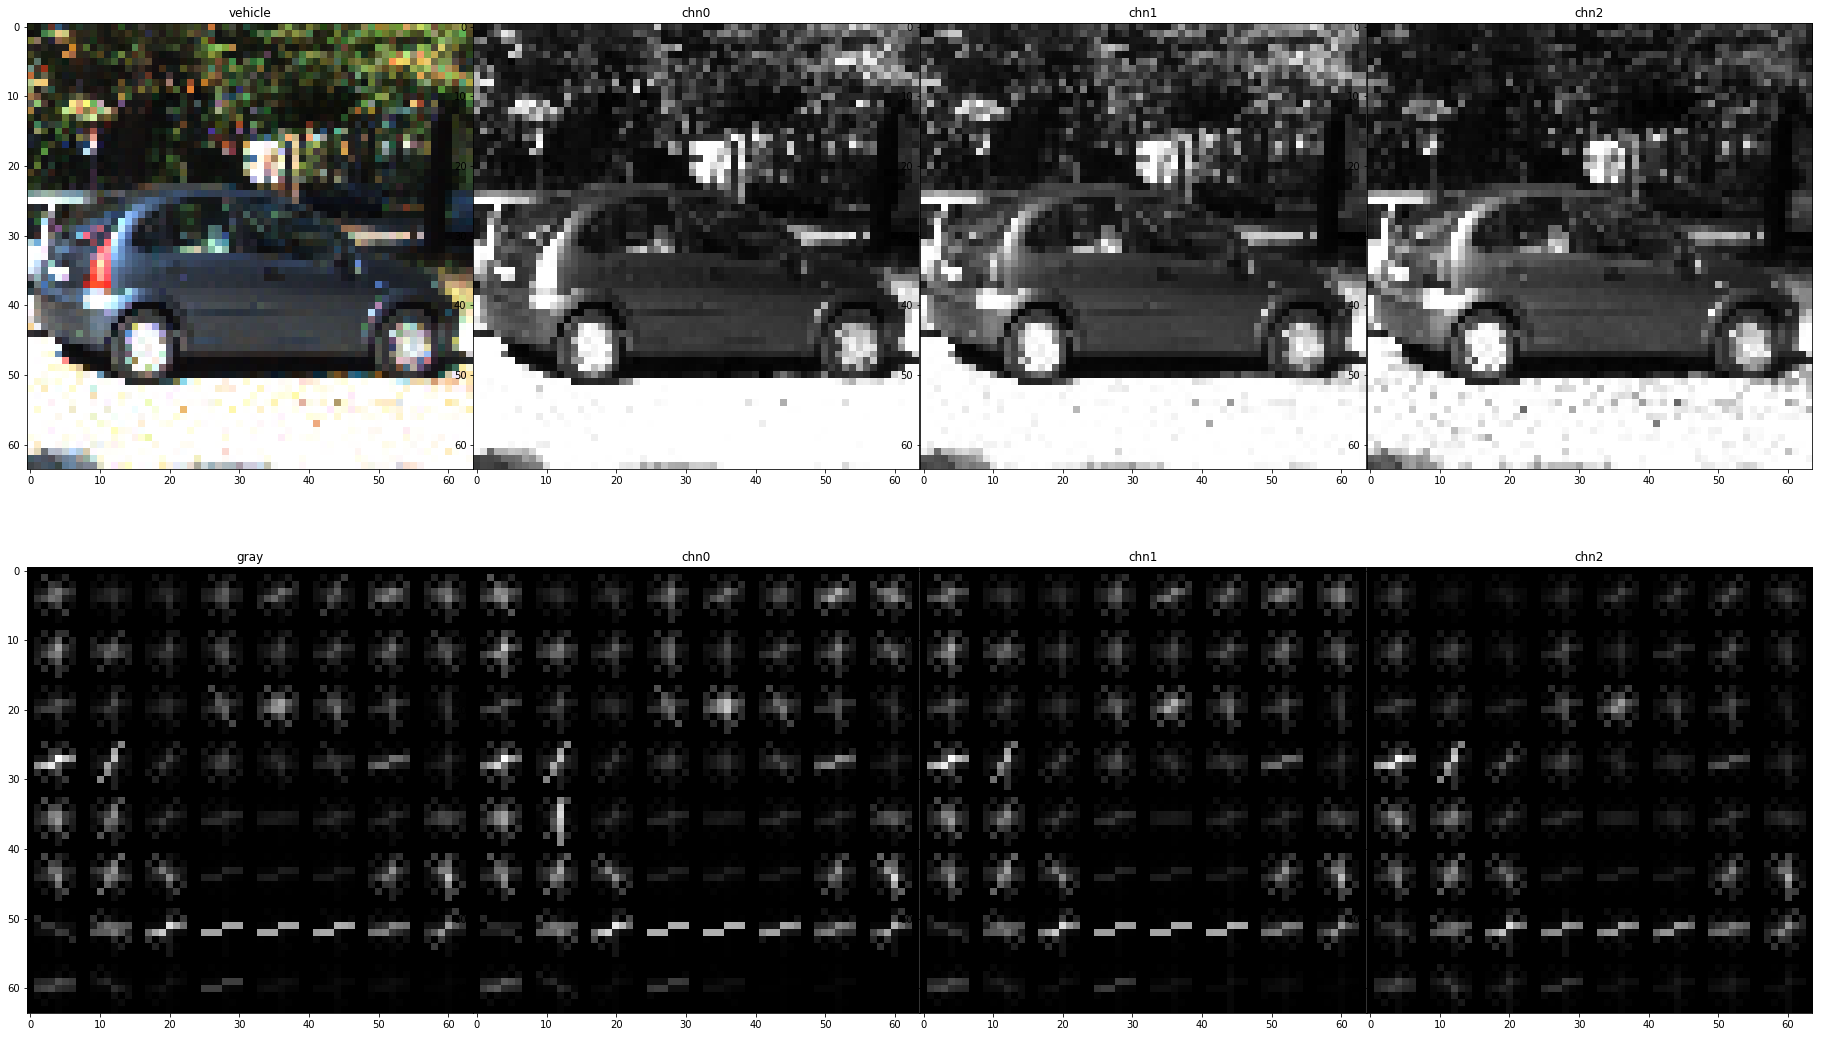

In [76]:
rnd = np.random.randint(0,len(all_veh)-1)


spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8 
cell_per_block=2 
hog_channel=0
                     
spatial_feat=True
hist_feat=True
hog_feat=True


veh_img = mpimg.imread(all_veh[rnd])
non_veh_img = mpimg.imread(all_non_veh[rnd])
gray = cv2.cvtColor(veh_img, cv2.COLOR_RGB2GRAY)
gray_non_veh = cv2.cvtColor(non_veh_img, cv2.COLOR_RGB2GRAY)
explore_hog(veh_img, gray, 'hog_veh_rgb')

./output_images/hog_veh_hls.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


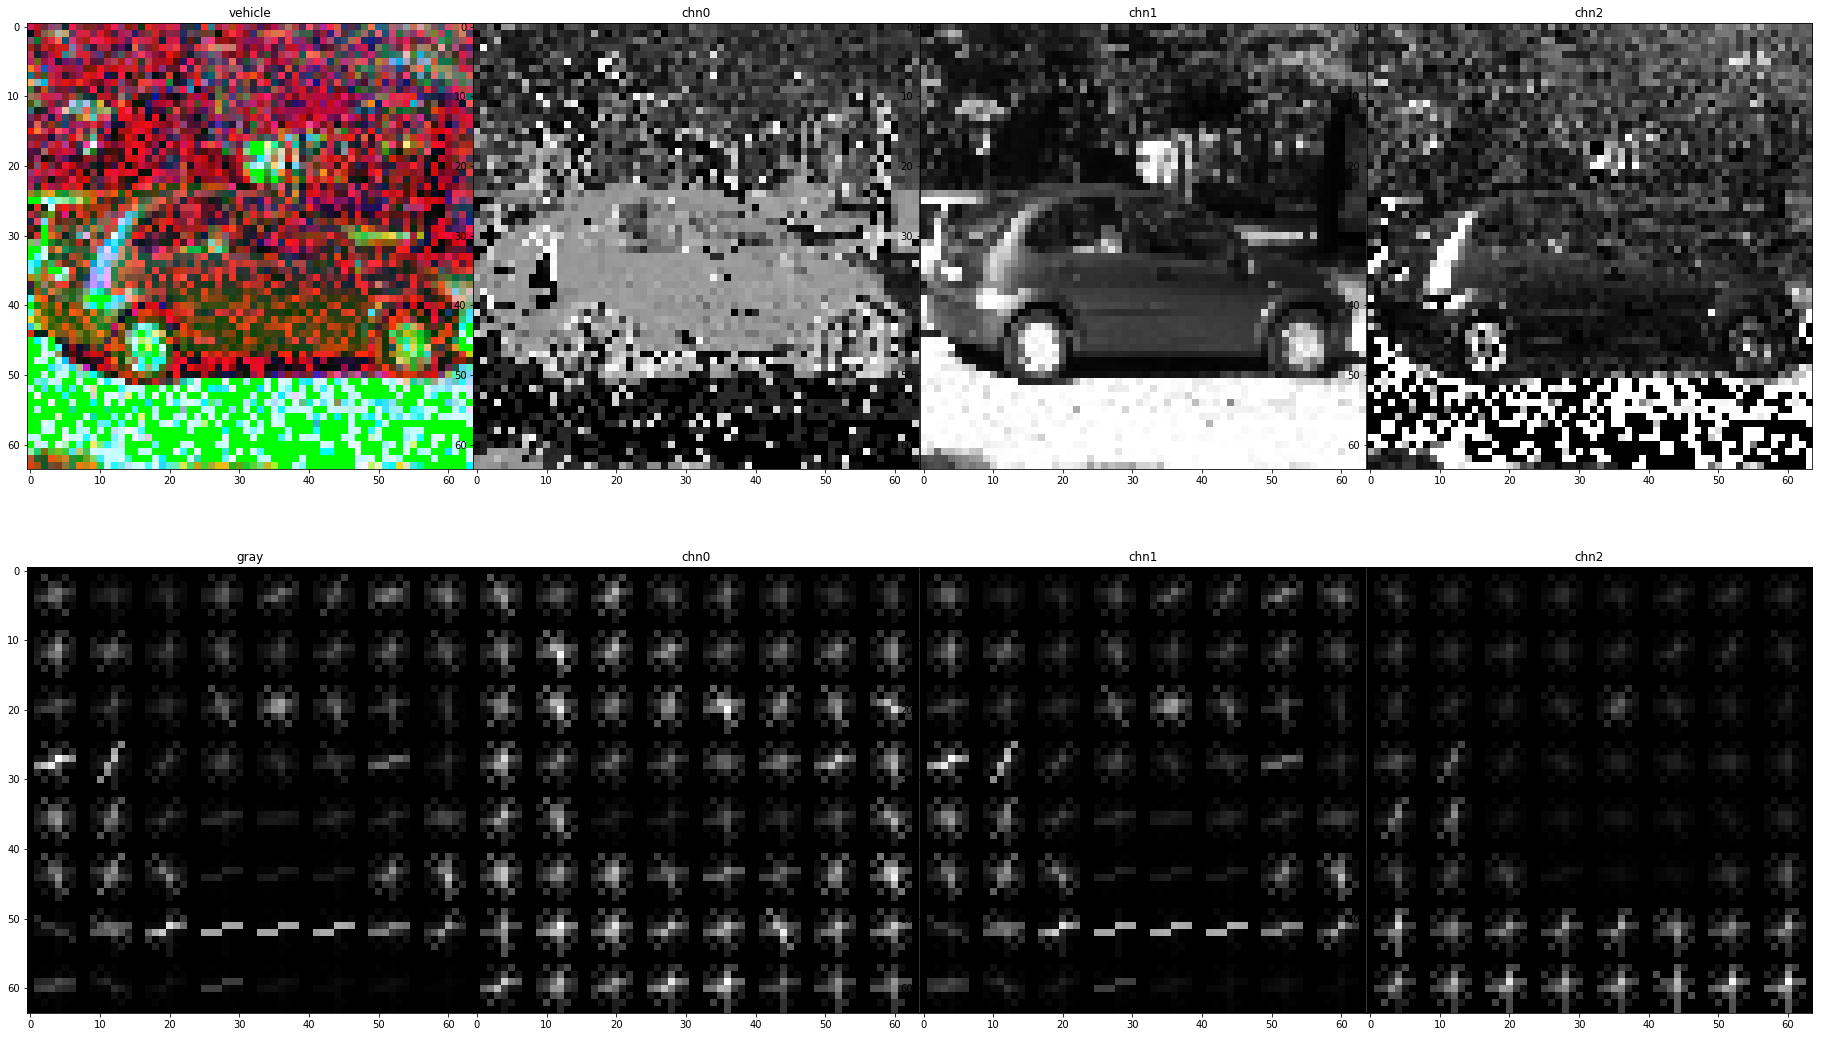

In [77]:
# veh_img = mpimg.imread(all_veh[rnd])

veh_img_hls = cv2.cvtColor(veh_img, cv2.COLOR_RGB2HLS)
# gray = cv2.cvtColor(image, cv2.COLOR_HLS2GRAY)
explore_hog(veh_img_hls,gray , 'hog_veh_hls')

./output_images/hog_veh_hsv.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


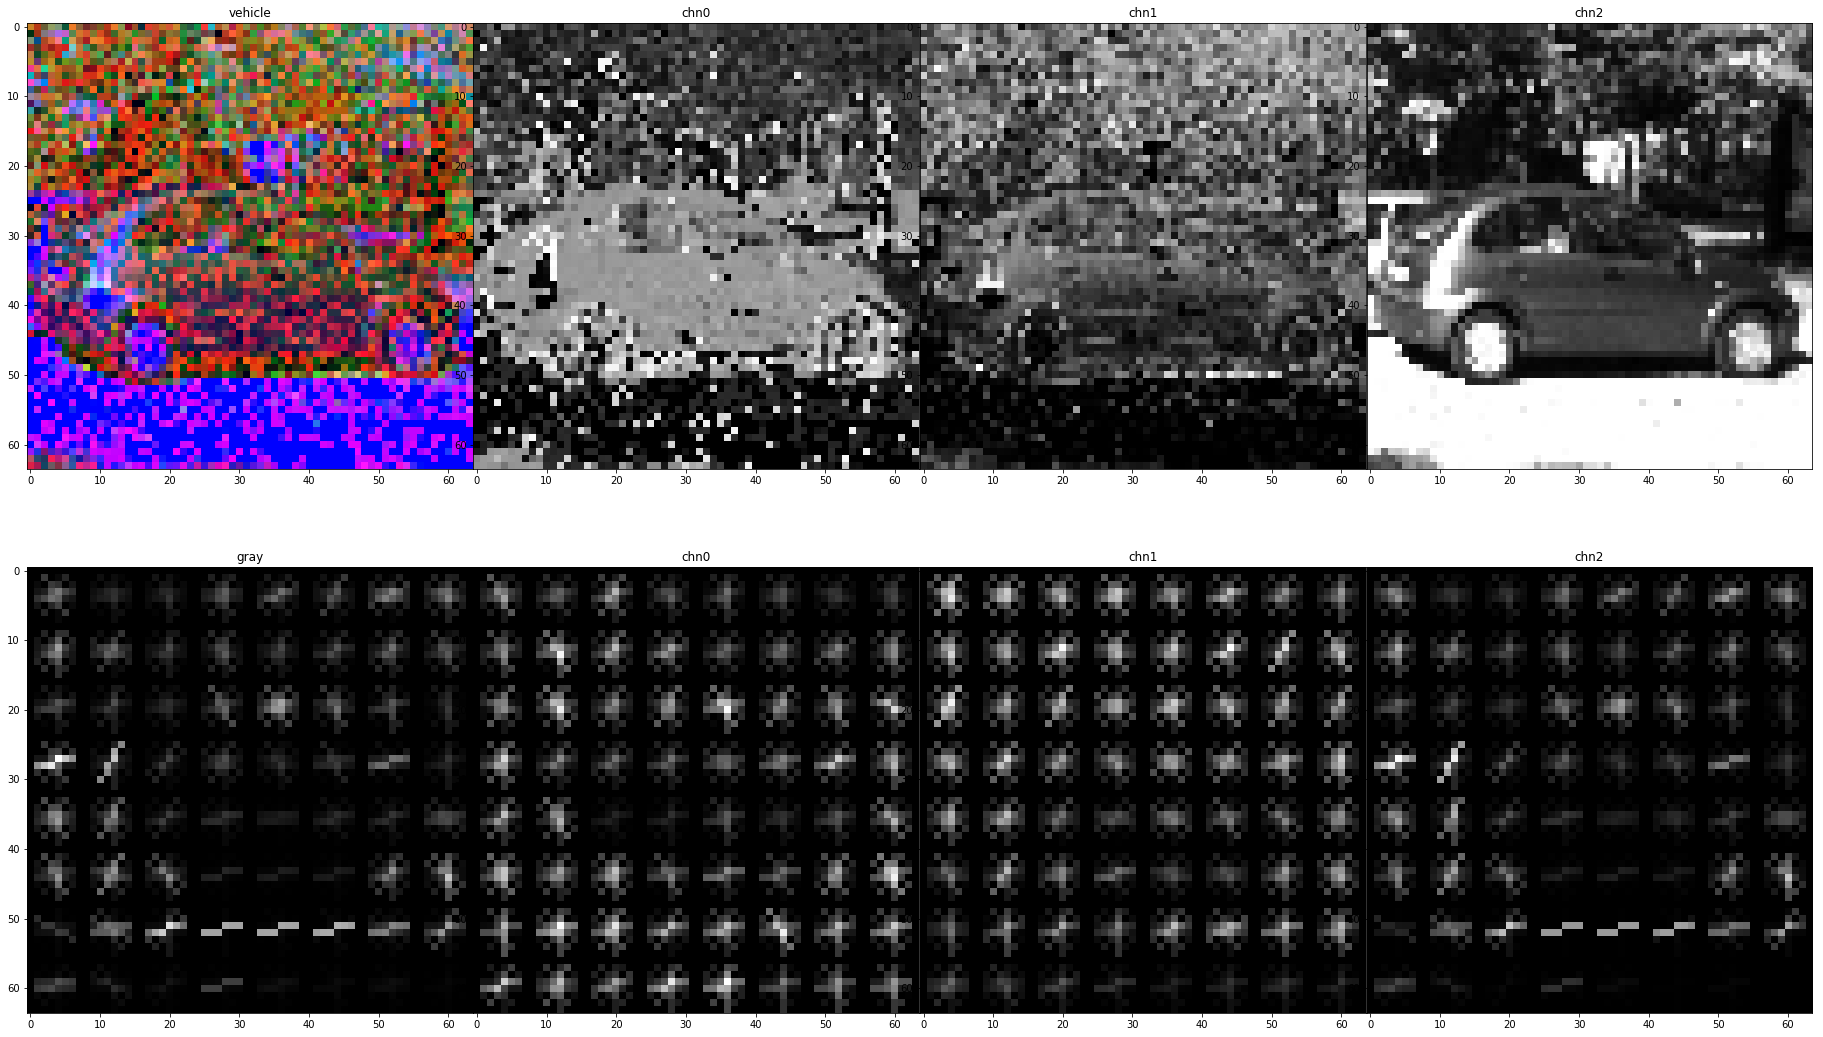

In [78]:
# veh_img = mpimg.imread(all_veh[rnd])

veh_img_hsv = cv2.cvtColor(veh_img, cv2.COLOR_RGB2HSV)
# gray = cv2.cvtColor(image, cv2.COLOR_HLS2GRAY)
explore_hog(veh_img_hsv,gray, 'hog_veh_hsv')

./output_images/hog_veh_ycrcb.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


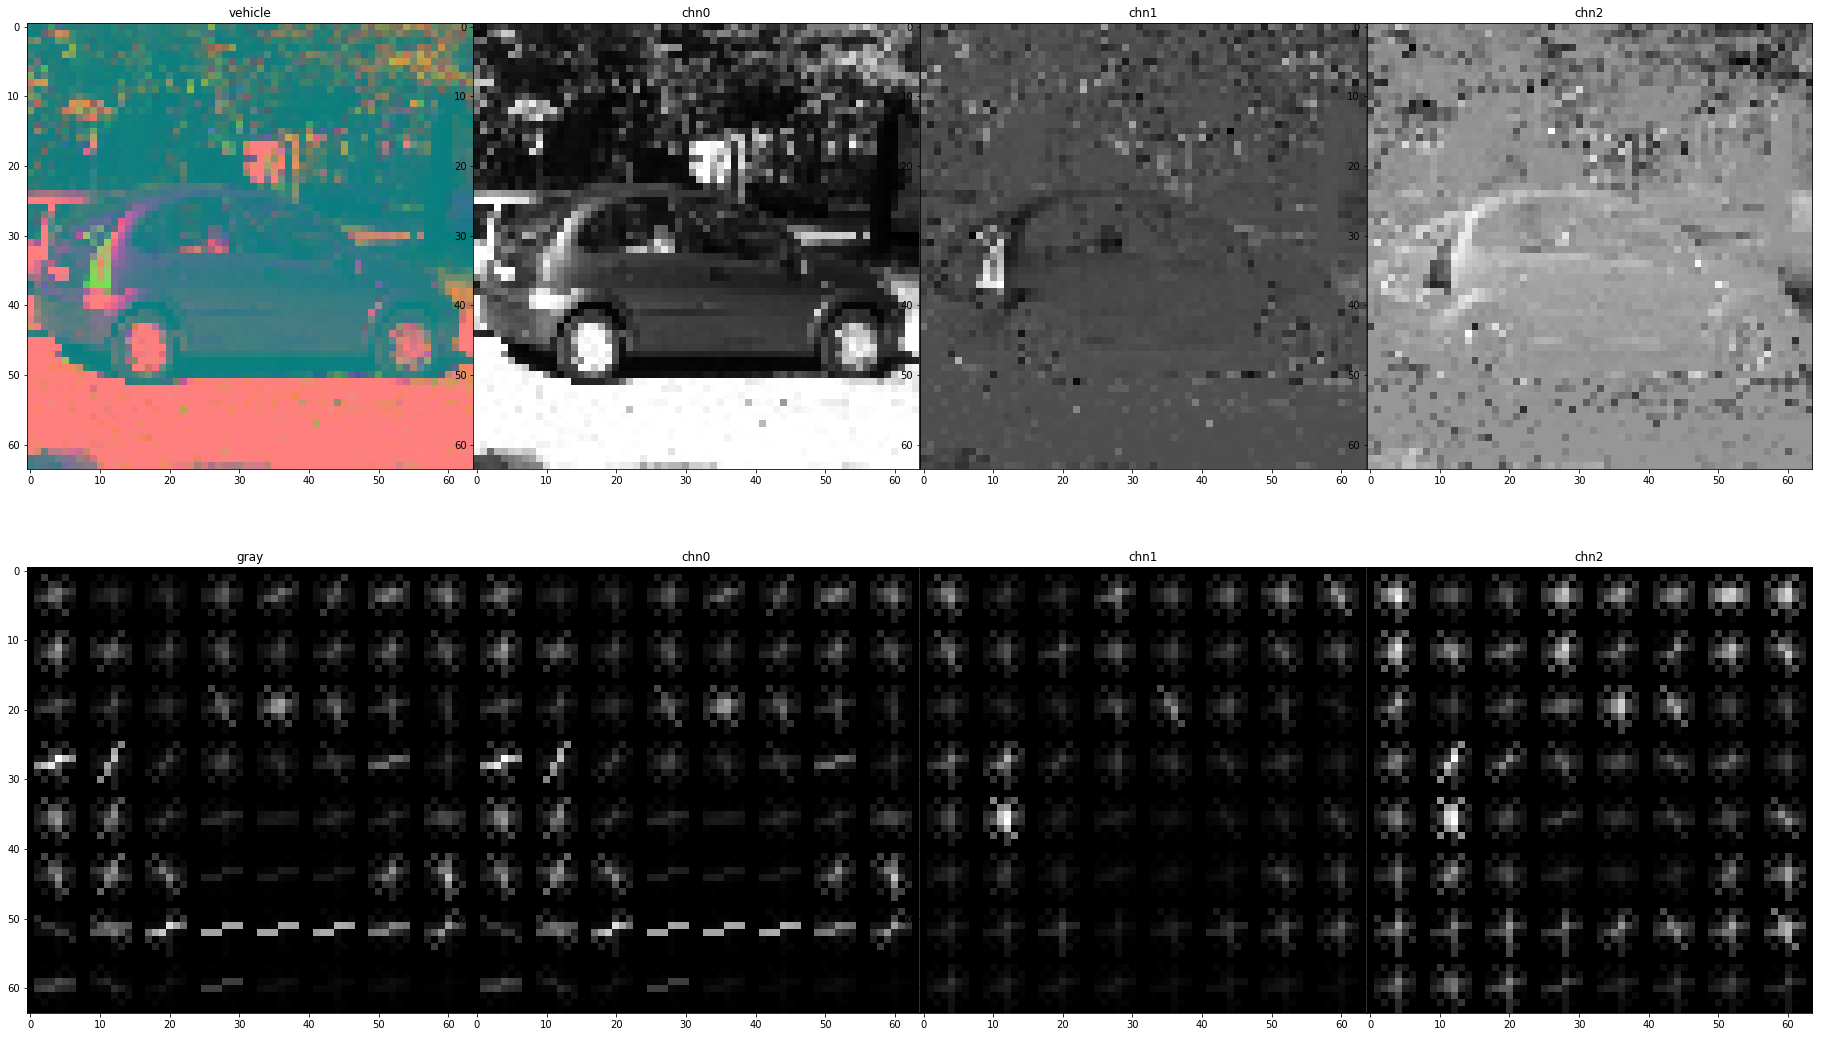

In [79]:
veh_img_ycrcb = cv2.cvtColor(veh_img, cv2.COLOR_RGB2YCrCb)
# gray = cv2.cvtColor(veh_img, cv2.COLOR_HLS2GRAY)
explore_hog(veh_img_ycrcb,gray, 'hog_veh_ycrcb')

./output_images/hog_veh_yuv.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


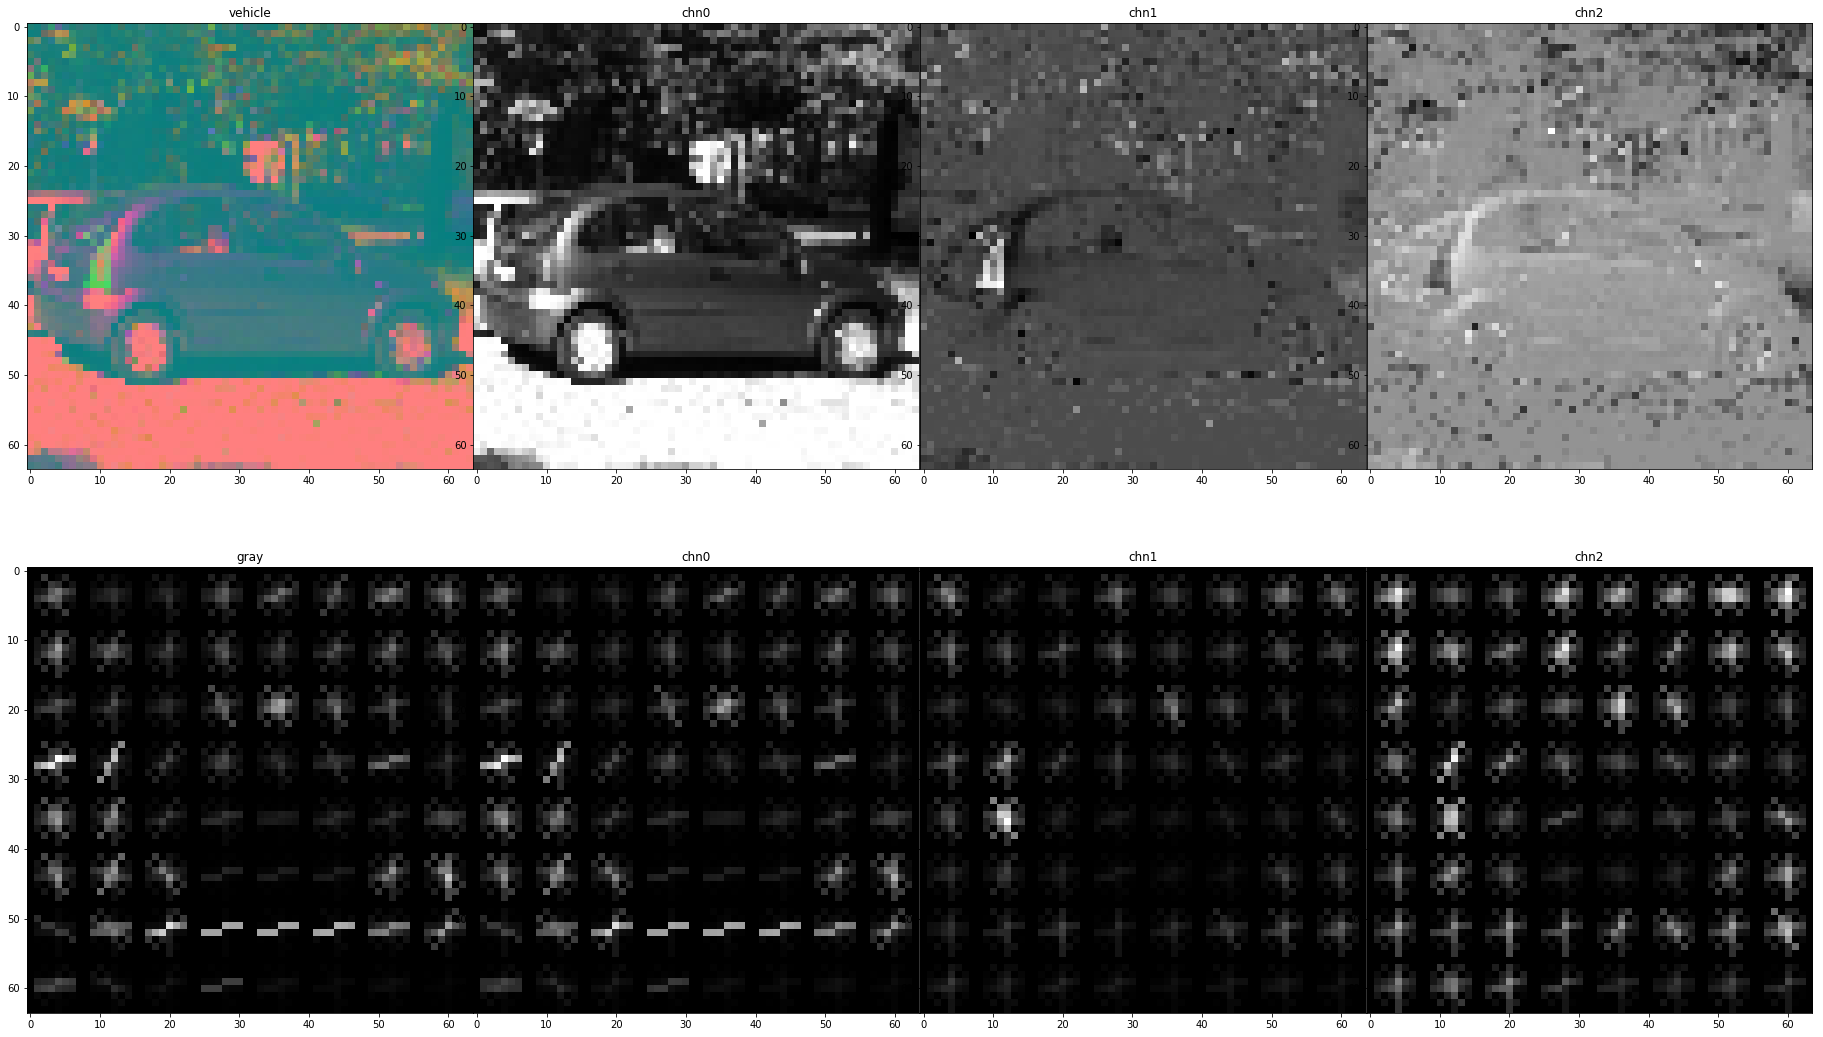

In [80]:
veh_img_yuv = cv2.cvtColor(veh_img, cv2.COLOR_RGB2YUV)
# gray = cv2.cvtColor(image, cv2.COLOR_HLS2GRAY)
explore_hog(veh_img_yuv,gray, 'hog_veh_yuv')

./output_images/hog_veh_luv.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


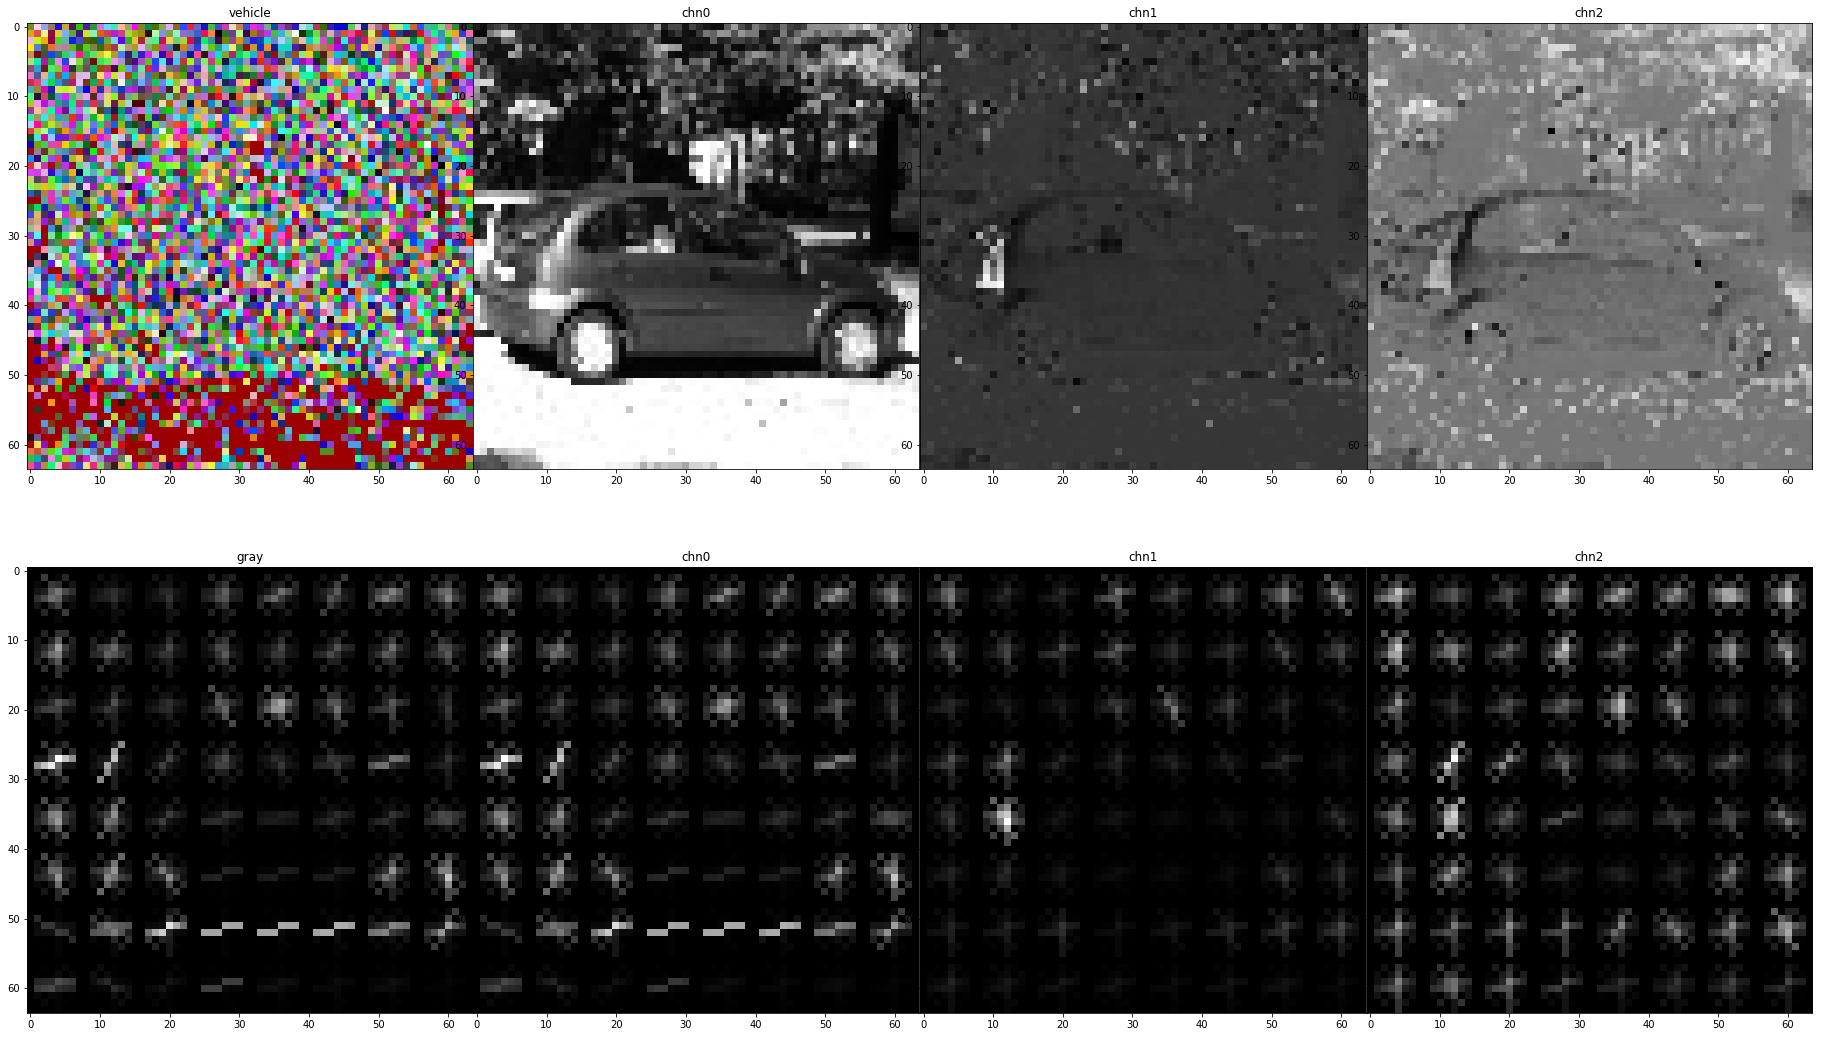

In [81]:
veh_img_luv = cv2.cvtColor(veh_img, cv2.COLOR_RGB2LUV)
# gray = cv2.cvtColor(image, cv2.COLOR_HLS2GRAY)
explore_hog(veh_img_luv,gray, 'hog_veh_luv')

./output_images/hog_veh_lab.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


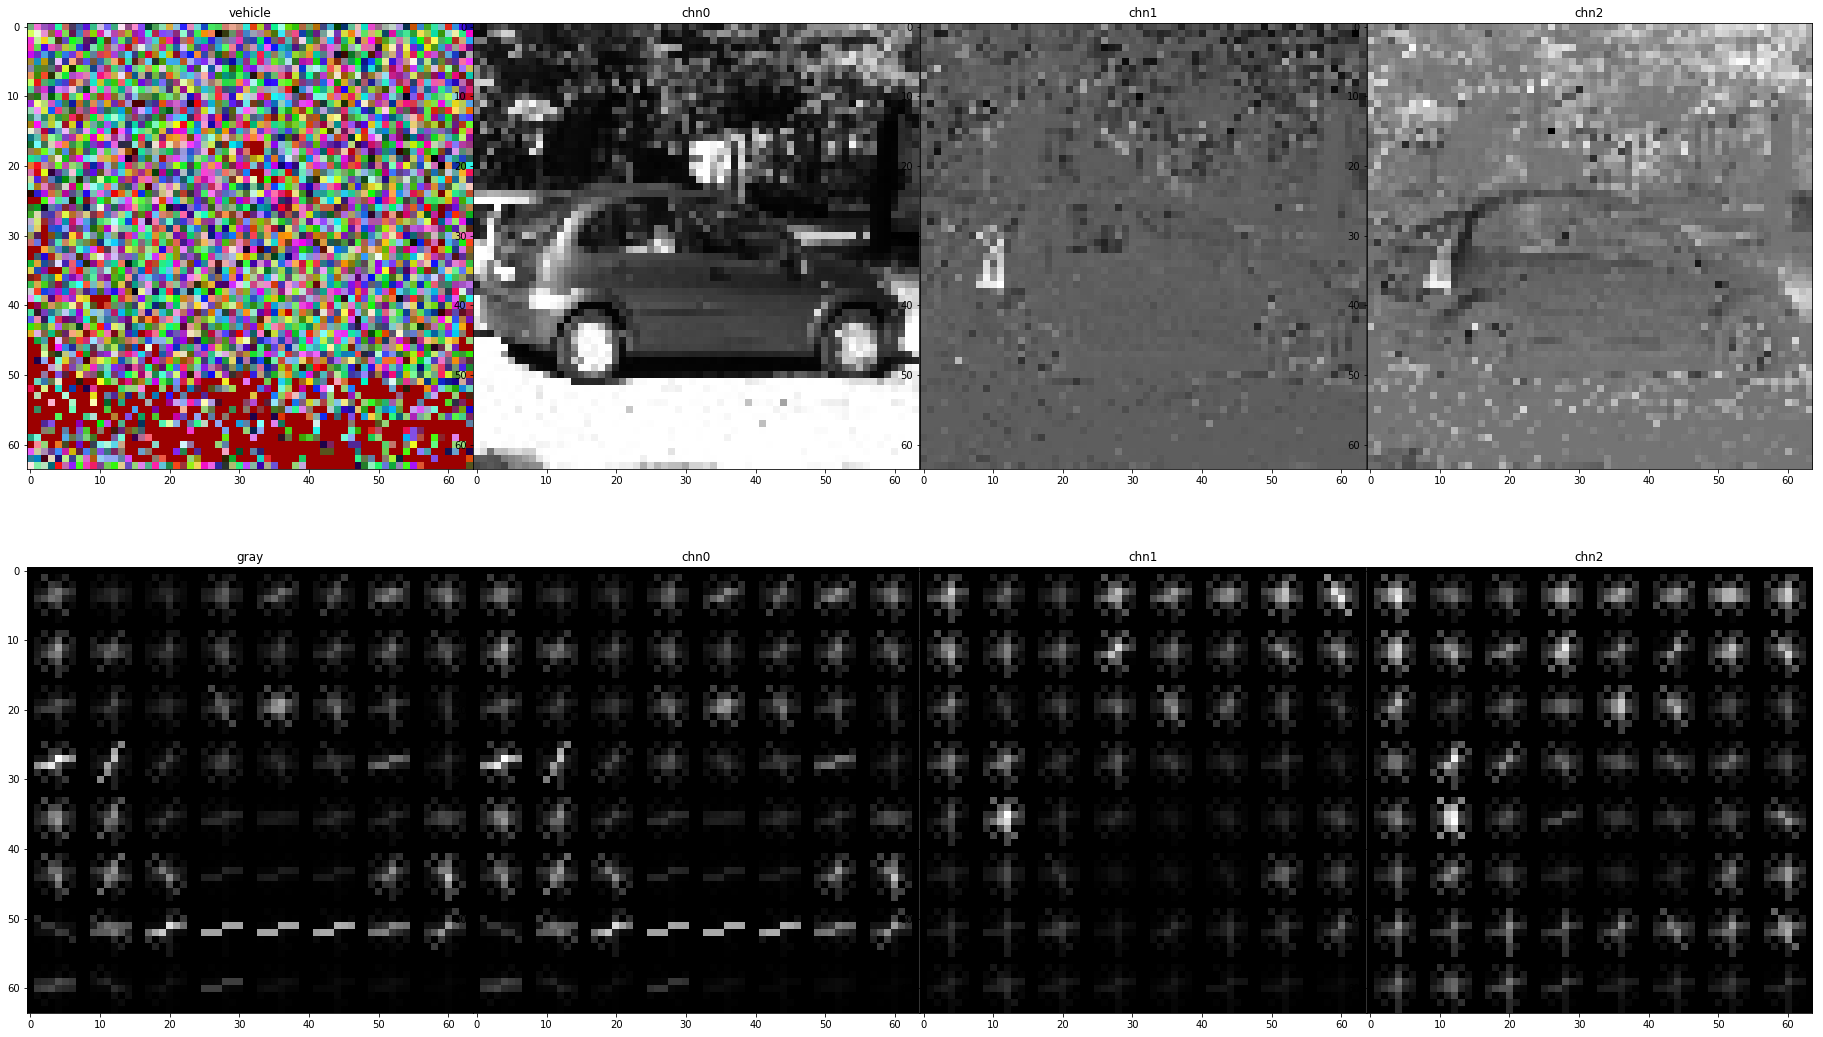

In [82]:
veh_img_lab = cv2.cvtColor(veh_img, cv2.COLOR_RGB2LAB)
# gray = cv2.cvtColor(image, cv2.COLOR_HLS2GRAY)
explore_hog(veh_img_lab,gray, 'hog_veh_lab')

./output_images/hog_non_veh_rgb.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


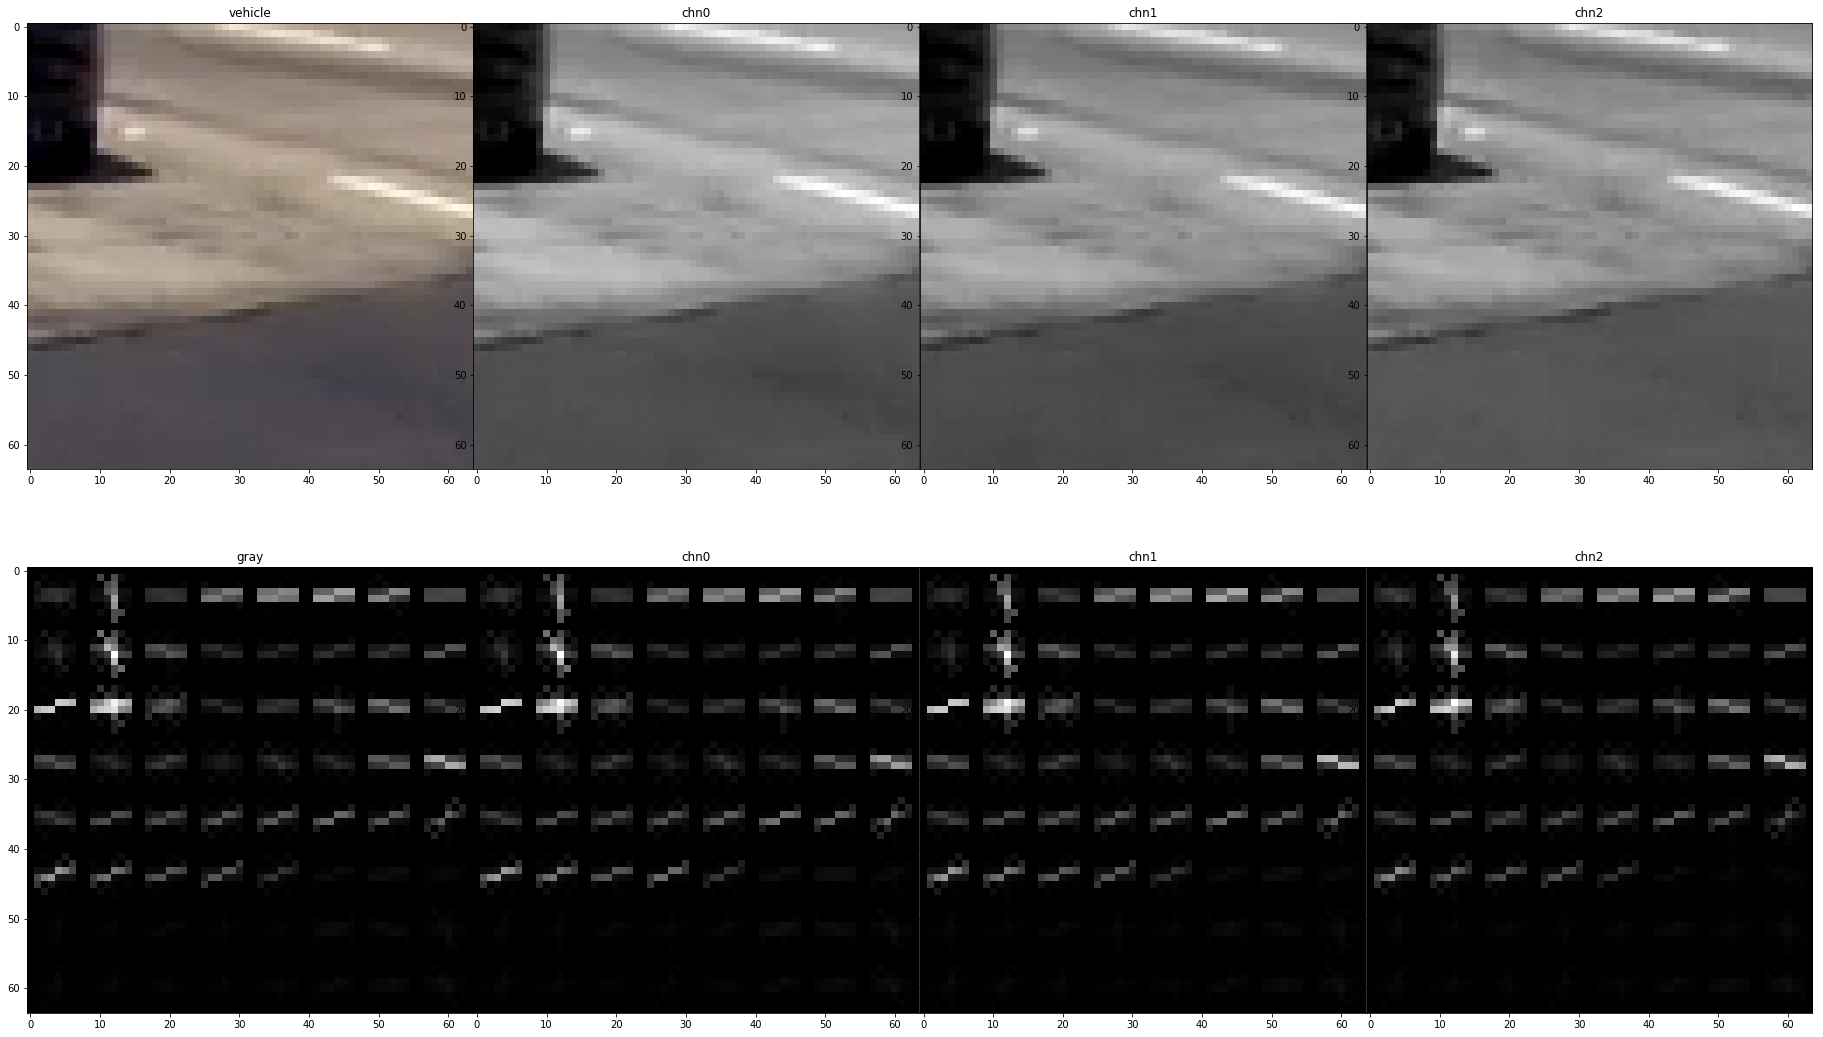

In [83]:
explore_hog(non_veh_img, gray_non_veh, 'hog_non_veh_rgb')

./output_images/hog_non_veh_hls.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


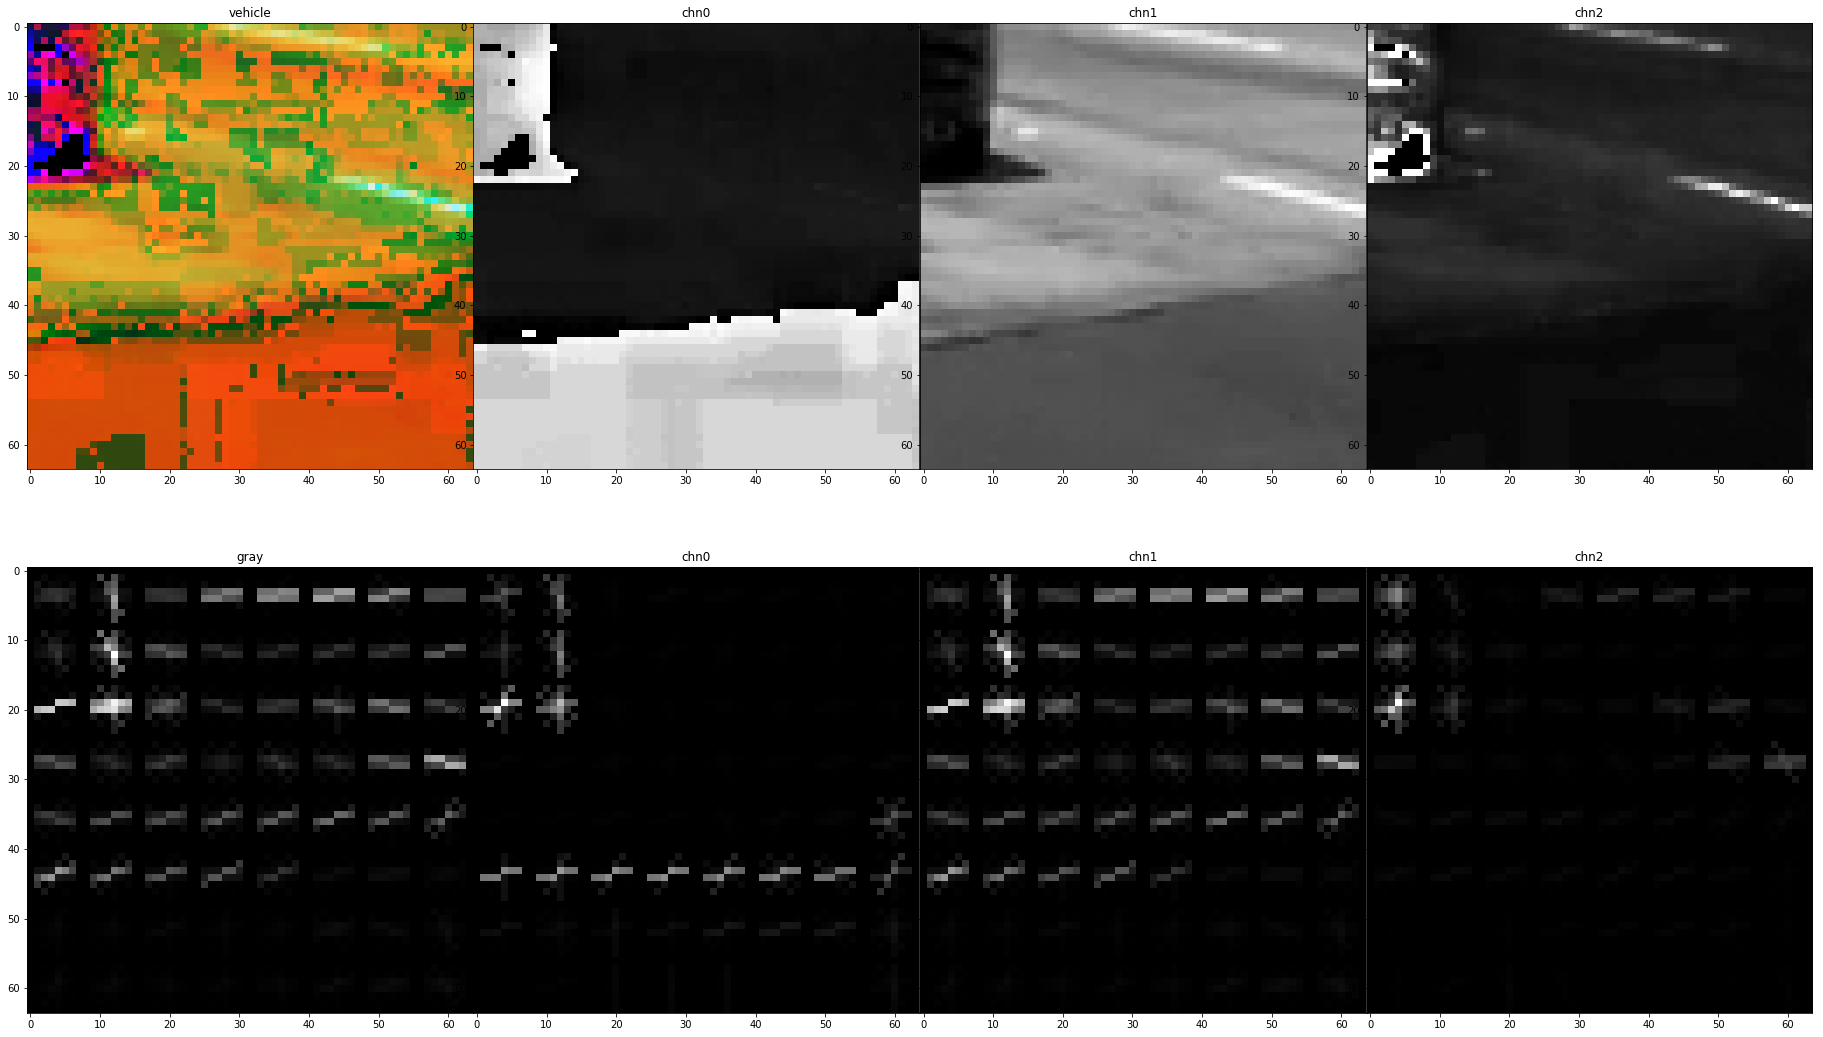

In [85]:
non_veh_img_hls = cv2.cvtColor(non_veh_img, cv2.COLOR_RGB2HLS)
# gray = cv2.cvtColor(image, cv2.COLOR_HLS2GRAY)
explore_hog(non_veh_img_hls,gray_non_veh , 'hog_non_veh_hls')

./output_images/hog_non_veh_hsv.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


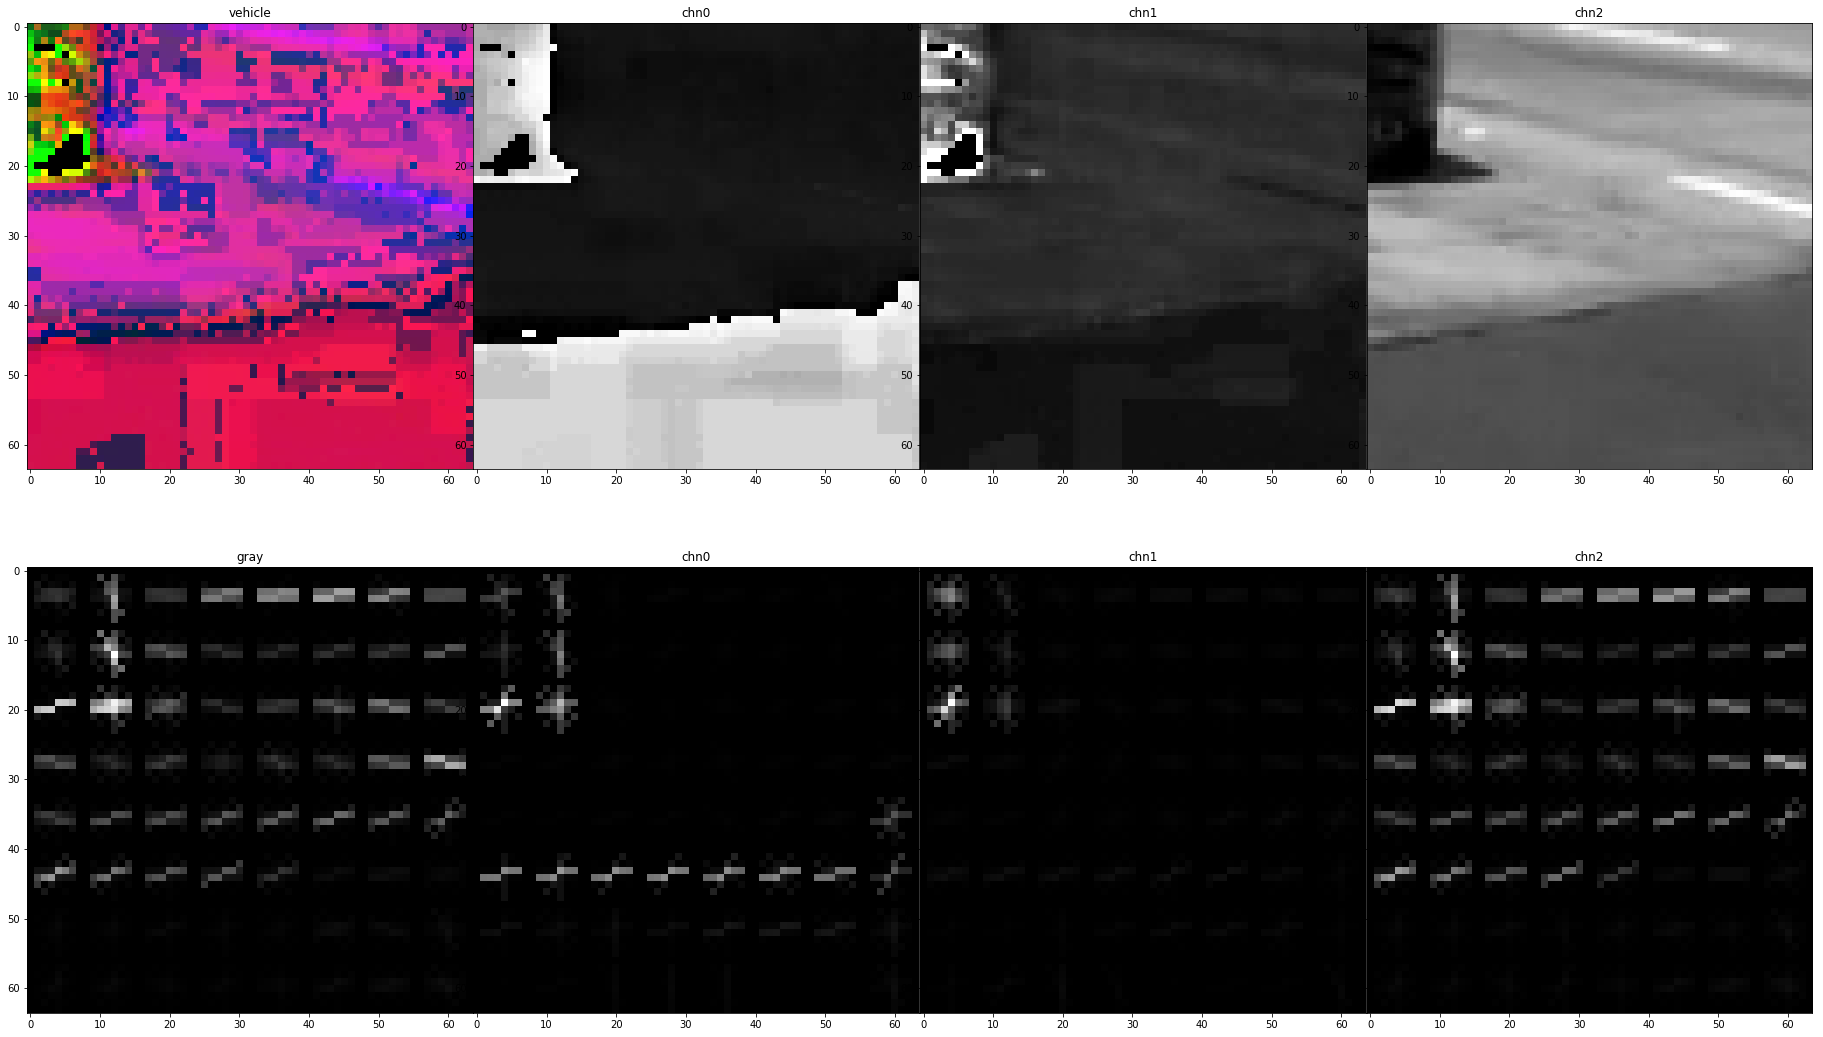

In [86]:
non_veh_img_hsv = cv2.cvtColor(non_veh_img, cv2.COLOR_RGB2HSV)
# gray = cv2.cvtColor(image, cv2.COLOR_HLS2GRAY)
explore_hog(non_veh_img_hsv,gray_non_veh, 'hog_non_veh_hsv')

./output_images/hog_non_veh_ycrcb.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


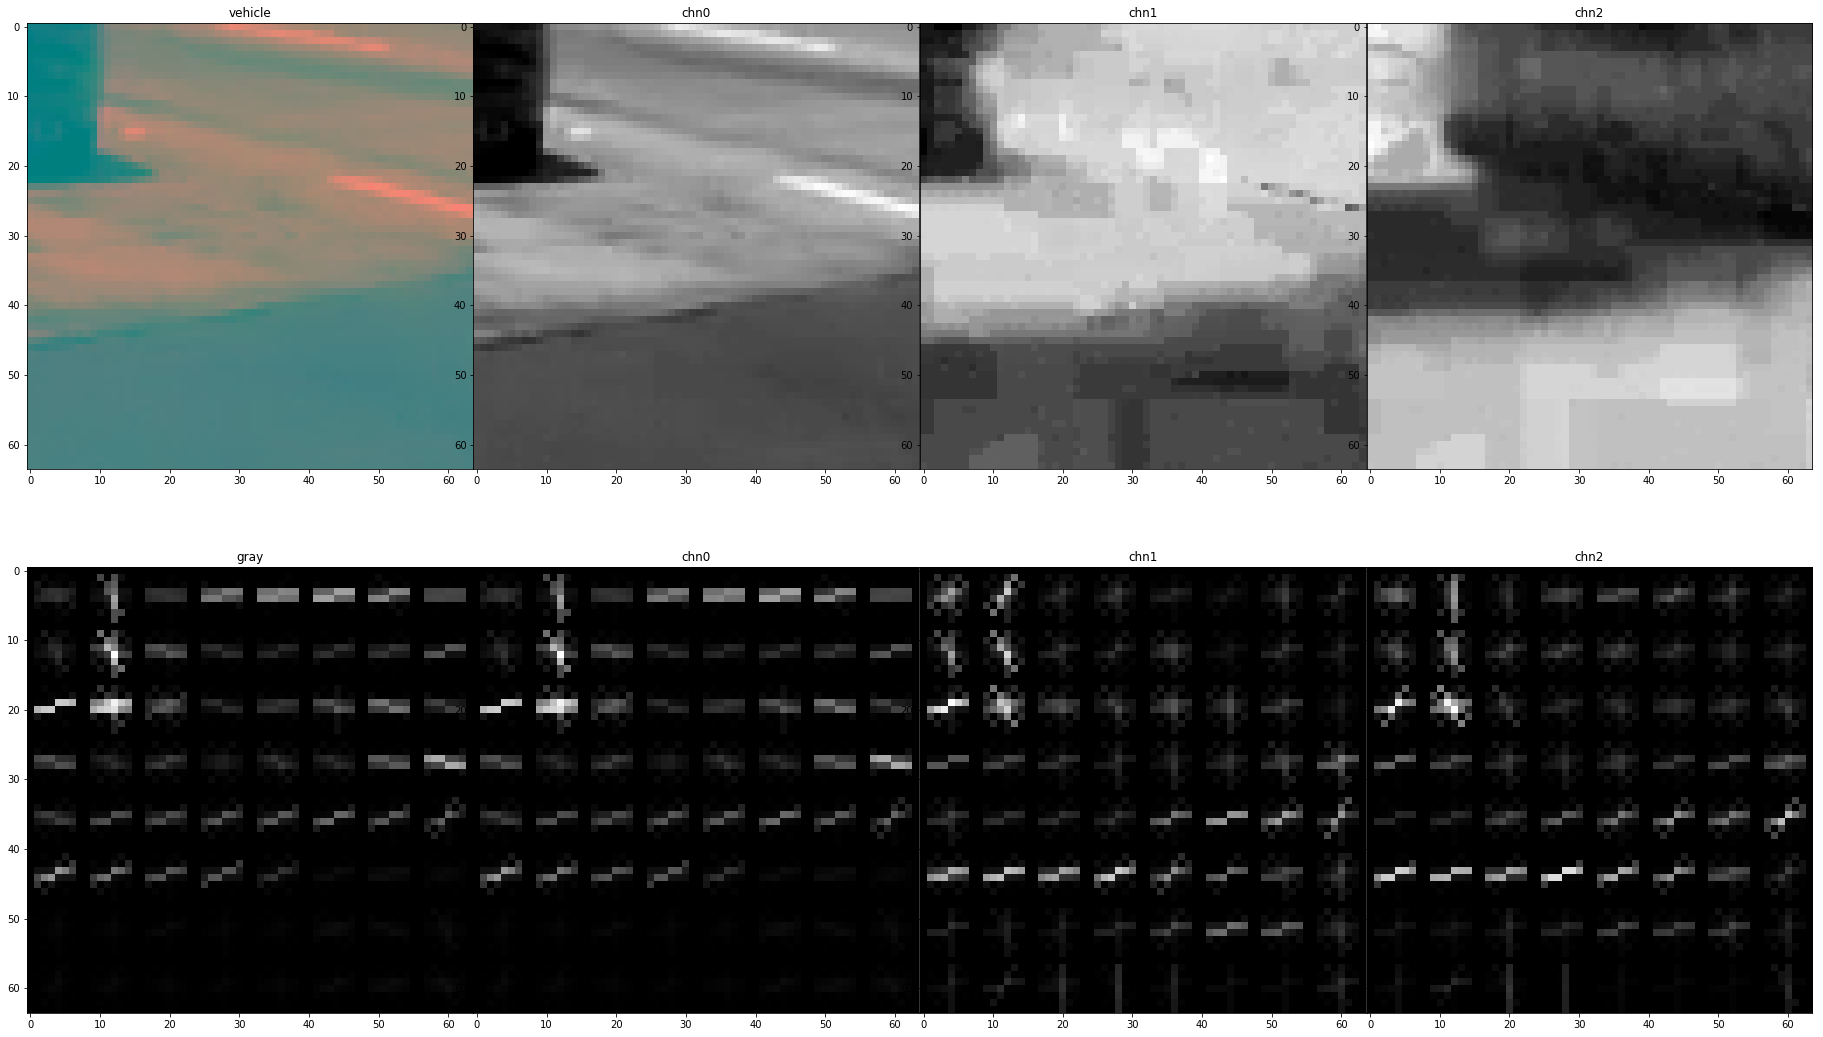

In [87]:
non_veh_img_ycrcb = cv2.cvtColor(non_veh_img, cv2.COLOR_RGB2YCrCb)
# gray = cv2.cvtColor(veh_img, cv2.COLOR_HLS2GRAY)
explore_hog(non_veh_img_ycrcb,gray_non_veh, 'hog_non_veh_ycrcb')

./output_images/hog_non_veh_yuv.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


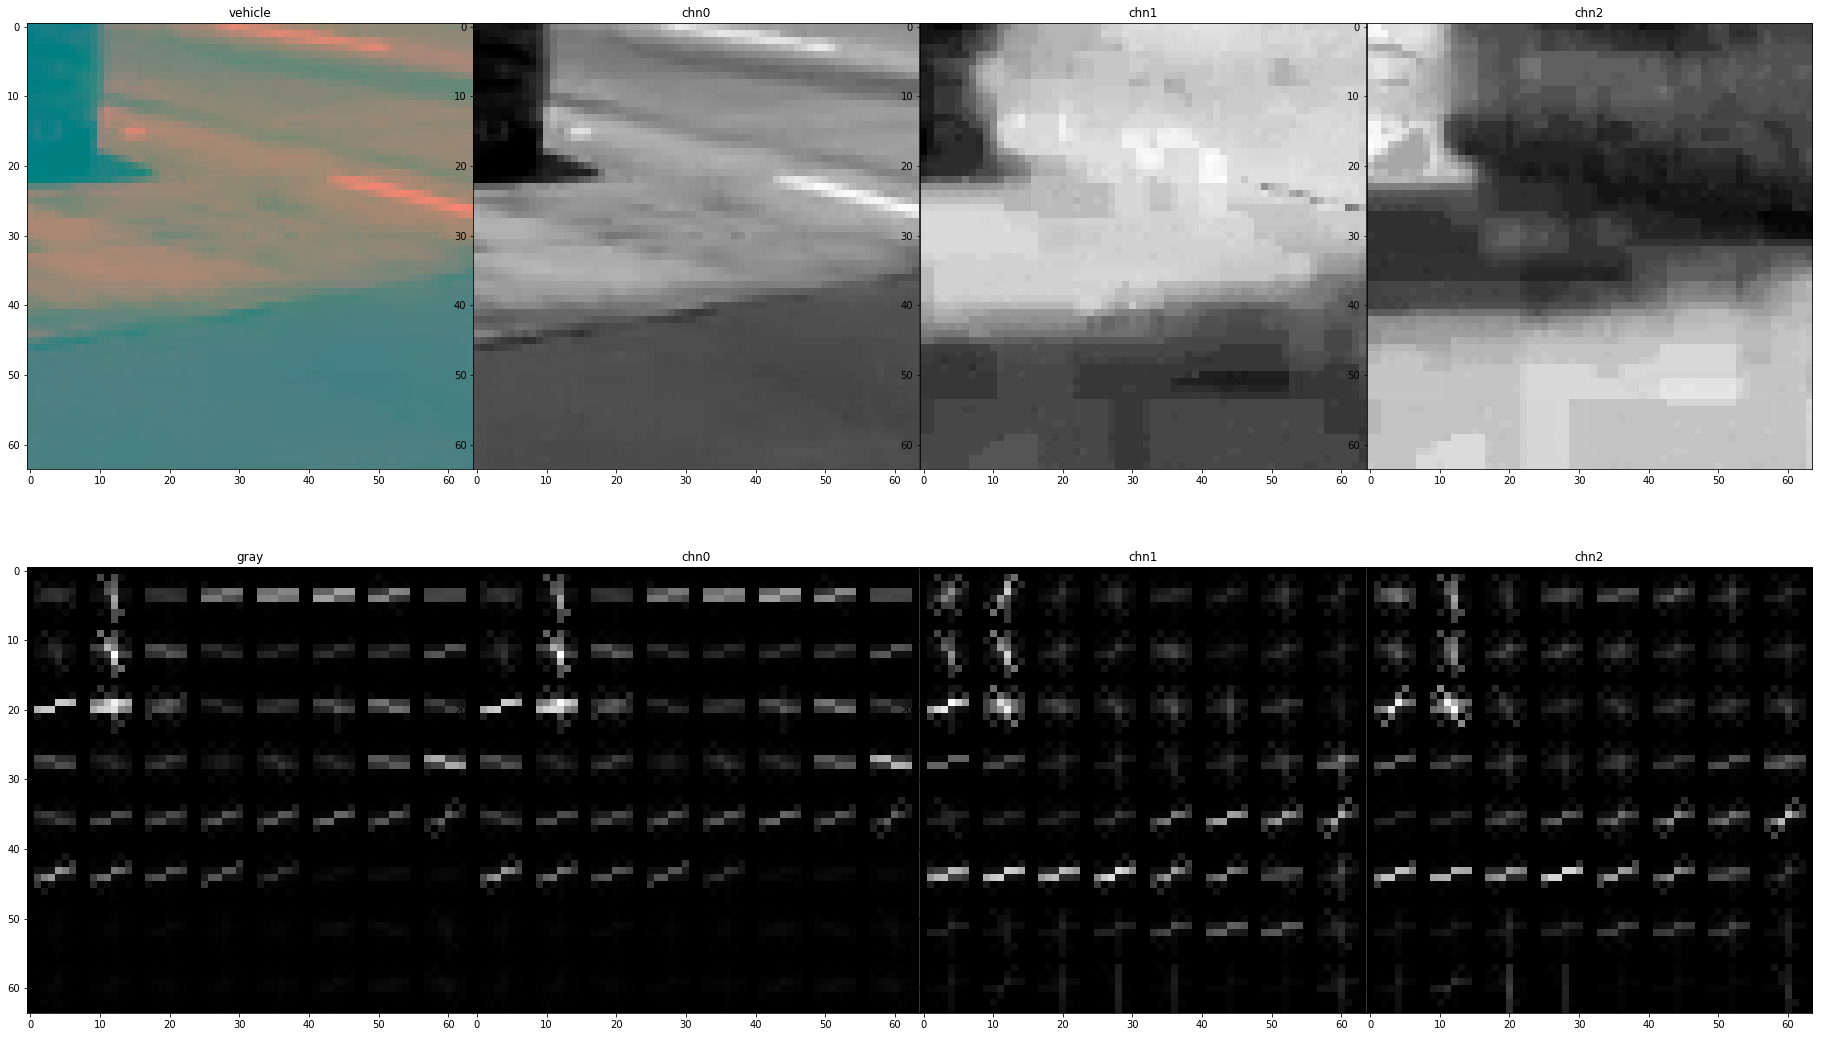

In [88]:
non_veh_img_yuv = cv2.cvtColor(non_veh_img, cv2.COLOR_RGB2YUV)
# gray = cv2.cvtColor(image, cv2.COLOR_HLS2GRAY)
explore_hog(non_veh_img_yuv,gray_non_veh, 'hog_non_veh_yuv')

./output_images/hog_non_veh_luv.png
function to visualise the dataset and hog output


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


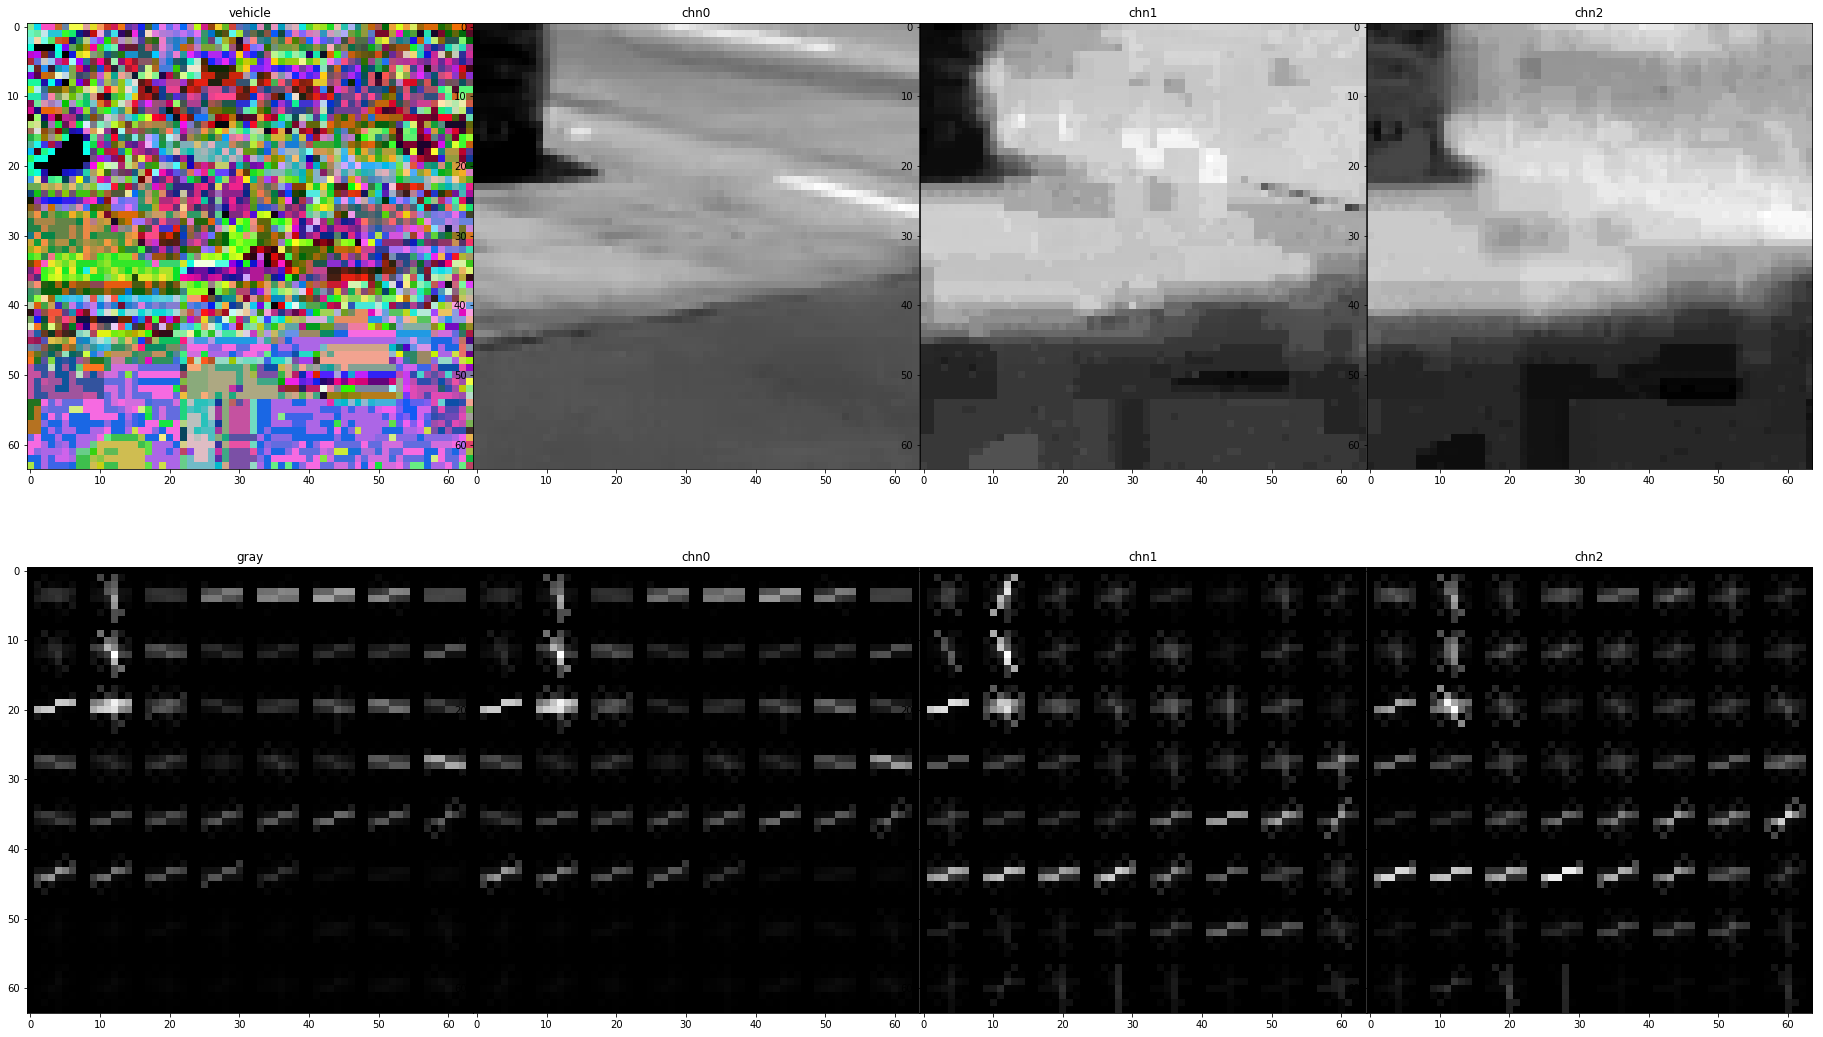

In [89]:
non_veh_img_luv = cv2.cvtColor(non_veh_img, cv2.COLOR_RGB2LUV)
# gray = cv2.cvtColor(image, cv2.COLOR_HLS2GRAY)
explore_hog(non_veh_img_luv,gray_non_veh, 'hog_non_veh_luv')

In [90]:
non_veh_img_lab = cv2.cvtColor(non_veh_img, cv2.COLOR_RGB2LAB)
# gray = cv2.cvtColor(image, cv2.COLOR_HLS2GRAY)
explore_hog(non_veh_img_lab,gray_non_veh, 'hog_non_veh_lab')

NameError: name 'gray_non_vehnon_' is not defined